In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import numpy as np
import json
import yaml
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

from scipy import ndimage as nd
from scipy import stats
import statsmodels.api as sm
from skimage.filters import rank
from skimage import filters, feature
from skimage.morphology import disk
from skimage.segmentation import clear_border, flood, flood_fill
from skimage.measure import regionprops, label
from sklearn import cluster, mixture
from skimage import morphology, measure
from skimage.draw import polygon2mask

import shapely
from shapely import geometry
import math
from collections import Counter

import torch

In [2]:
#read data of JE herbarium downloaded from gbif
gbif_occ = pd.read_csv('GBIF/occurrence.txt', sep='\t')[['gbifID', 'eventDate', 'countryCode',
                                                         'verbatimScientificName', 'elevation',
                                                        'decimalLatitude', 'decimalLongitude']]

#read file with image links
img_files = pd.read_csv('GBIF/multimedia.txt', sep='\t')

In [10]:
img_files[img_files['gbifID'] == 3029007469]['identifier'].values[0].split('&')[0]

'http://www.jacq.org/image.php?filename=425073'

In [312]:
#print species with at least 15 specimens with elevation information
#for spec in Counter(gbif_occ['verbatimScientificName']):
#    elev = gbif_occ[gbif_occ['verbatimScientificName'] == spec]['elevation'].dropna()
#    if len(elev) > 15:
#        print(spec)

In [313]:
#extract viola records
viola_records = gbif_occ[gbif_occ['verbatimScientificName'] == 'Viola thomasiana Songeon & E. P. Perrier'].sort_values('elevation')

In [ ]:
#download specimen images
img_IDs = gbif_occ[(gbif_occ['verbatimScientificName'] == 'Viola thomasiana Songeon & E. P. Perrier')]['gbifID']
for img_ID in img_IDs:
    img_link = img_files[img_files['gbifID'] == img_ID]['identifier'].values[0].split('&')[0]
    !wget -c {img_link} -O images_Viola/{img_ID}.jpeg

## Feature extraction from image

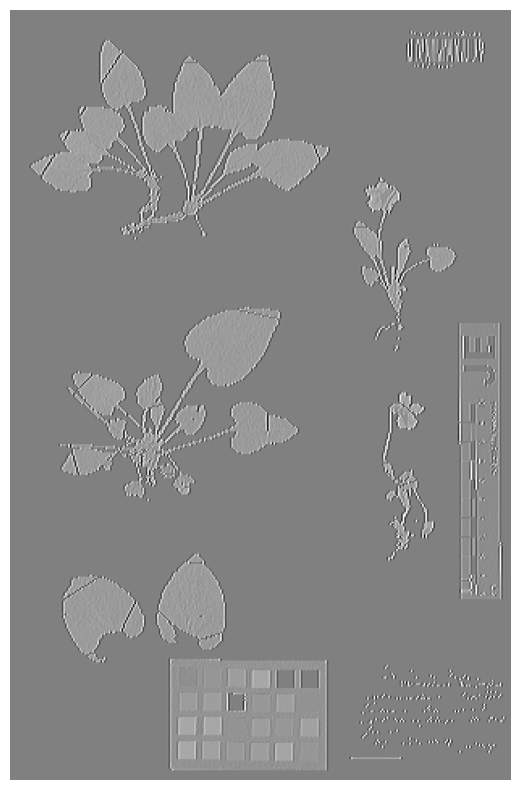

In [127]:
img_ID = 3029007469

#read image
img_cv = cv2.imread(f'images_Viola/{img_ID}.jpeg')
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
img_cv = cv2.resize(img_cv, (0,0), fx=0.1, fy=0.1) 
#remove border
img_cv = img_cv[5:-5, 5:-5, :]
#----------------------------------------------------------------------------
#basic features
#extract rgb channels
r_channel, g_channel, b_channel = cv2.split(img_cv)
#extract pixel coordinates
img_indices = np.dstack(np.indices(img_cv.shape[:2]))
#---------------------------------------------------------------------------
#basic filters
#transform to gray
img_gray = cv2.cvtColor(img_cv,cv2.COLOR_RGB2GRAY)
#apply binary threshold
img_thr = filters.threshold_otsu(img_gray)
img_bin = (img_gray>img_thr)
img_bin_mask = img_bin == 0

#mask rgb and gray images
img_cv_bin_masked = cv2.bitwise_and(img_cv, img_cv, mask=(img_bin_mask*1).astype('uint8') )
img_gray_bin_masked = cv2.bitwise_and(img_gray, img_gray, mask=(img_bin_mask*1).astype('uint8') )
#----------------------------------------------------------------------------
#Convolution filters
#detect edges
img_edge = feature.canny(img_gray, sigma=3)
#img_modal = rank.modal(img_gray, footprint=disk(1))
#img_gaus = cv2.GaussianBlur(img_gray, (5, 5), 10, borderType=cv2.BORDER_REFLECT)
img_mean = cv2.blur(img_gray,(15,15))
#----------------------------------------------------------------------------
#gabor filters
#https://www.youtube.com/watch?v=1GUgD2SBl9A&ab_channel=DigitalSreeni
#https://www.youtube.com/watch?v=yn1NUwaxhZg&ab_channel=ZEISSarivis
k_size = 15
sigma = 0.5
theta = 2
lamda = 0.8
gamma = 0.6
phi = 0.1
gb_kernel = cv2.getGaborKernel((k_size, k_size), sigma, theta, lamda, gamma, phi, ktype = cv2.CV_32F)
img_gb = cv2.filter2D(img_gray_bin_masked, cv2.CV_8SC3, gb_kernel)

#----------------------------------------------------------------------------

#clip image
img_cliped = img_mean[390:410, 1645:1665]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=True)
ax.imshow(img_gb, cmap='gray')
#ax.plot([1645, 1665, 1665, 1645, 1645], [410, 410, 390, 390, 410], c=(1, 0, 0), lw=0.5)
ax.axis('off')
plt.savefig('jena.png', dpi=900)

## Clustering

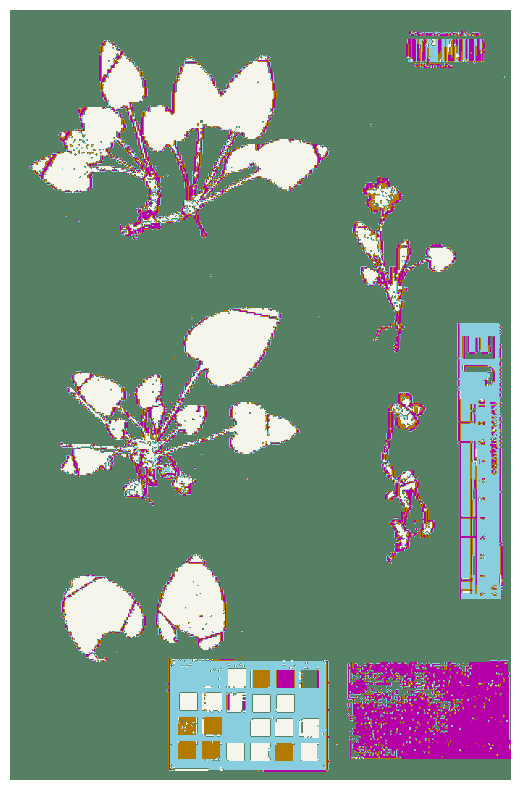

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=True)
 
#Clustering predictor matrix
filters_img = np.concatenate((img_cv,
                             #img_indices,
                             img_gb.reshape(img_gb.shape[0], img_gb.shape[1], 1),
                            ), axis=-1)

X = np.reshape(filters_img, [-1,filters_img.shape[2]])

#----------------------------------------------------------
n_clstr = 5
kmeans = cluster.MiniBatchKMeans(n_clusters=n_clstr, init='k-means++', max_iter=300, n_init=5, tol=0.0001).fit(X)
kmeans_img = np.reshape(kmeans.labels_, img_cv.shape[:2])
#----------------------------------------------------------
n_comp = 5
gaus = mixture.GaussianMixture(n_components=n_comp, covariance_type='full', tol=0.0001,
                               n_init=5, init_params='k-means++', random_state = 7)
y_gaus = gaus.fit(X).predict(X)
gaus_img = np.reshape(y_gaus, img_cv.shape[:2])
#----------------------------------------------------------

##### Label masking ######################################################
# Find the contours in selected image and identify big parallelograms
label_masks = []
image_surface = img_cv.shape[0]*img_cv.shape[1]
#for cls in range(n_comp):
#    contours_kmeans = measure.find_contours(gaus_img == cls, 0.8)
#    contours_gaus = measure.find_contours(kmeans_img == cls, 0.8)
#    #contours = cv2.findContours(img_bin*1, cv2.RETR_FLOODFILL,  cv2.CHAIN_APPROX_NONE)[0]
#    #contours = [np.array([list(i[0]) for i in x]) for x in contours]
#    for contour in contours_gaus:
#        poly = geometry.Polygon(geometry.Point(i) for i in contour)
#        bbox = geometry.box(poly.bounds[0], poly.bounds[1], poly.bounds[2], poly.bounds[3])
#        if poly.area > bbox.area*0.9 and poly.area < image_surface*0.5 and poly.area > image_surface*0.005:
#            #ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color=(1, 0, 0))
#            label_masks.append(bbox)
#        
#    for contour in contours_kmeans:
#        poly = geometry.Polygon(geometry.Point(i) for i in contour)
#        bbox = geometry.box(poly.bounds[0], poly.bounds[1], poly.bounds[2], poly.bounds[3])
#        if poly.area > bbox.area*0.9 and poly.area < image_surface*0.5 and poly.area > image_surface*0.005:
#            #ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color=(1, 0.5, 1))
#            label_masks.append(bbox)



mask_list = [polygon2mask((img_cv.shape[0], img_cv.shape[1]), list(zip(m_poly.exterior.coords.xy[0], m_poly.exterior.coords.xy[1]))) 
            for m_poly in label_masks]

all_labels = sum(mask_list) < 1

#cmap = LinearSegmentedColormap.from_list('four_colors', [(0.961, 0.961, 0.929), (0.341, 0.502, 0.392), (0.541, 0.808, 0.878), (0.71, 0, 0.655), (.7, 0.486, 0)], N=5)
cmap = LinearSegmentedColormap.from_list('four_colors', [(0.961, 0.961, 0.929),  (0.341, 0.502, 0.392), (0.541, 0.808, 0.878), (.7, 0.486, 0), (0.71, 0, 0.655)], N=5)
#cmap = LinearSegmentedColormap.from_list('five_colors', [(0.961, 0.961, 0.929), (0.541, 0.808, 0.878), (0.71, 0, 0.655), (0.341, 0.502, 0.392), (.7, 0.486, 0)], N=5)
ax.imshow(kmeans_img, cmap=cmap)
#ax.imshow(gaus_img, cmap=cmap)
ax.axis('off')
plt.savefig('jena.png', dpi=900)

# Segment Anything Model

In [54]:
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [ ]:
#https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb#scrollTo=391771c1

In [130]:
image = cv2.imread(f'images_Viola/{img_ID}.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (0,0), fx=0.1, fy=0.1)

In [110]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(model=sam,
    points_per_side=32,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.94,
    crop_n_layers=0,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=10,  # Requires open-cv to run post-processing)
    )

In [111]:
masks = mask_generator.generate(image)

In [112]:
print(len(masks))
print(masks[0].keys())

75
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


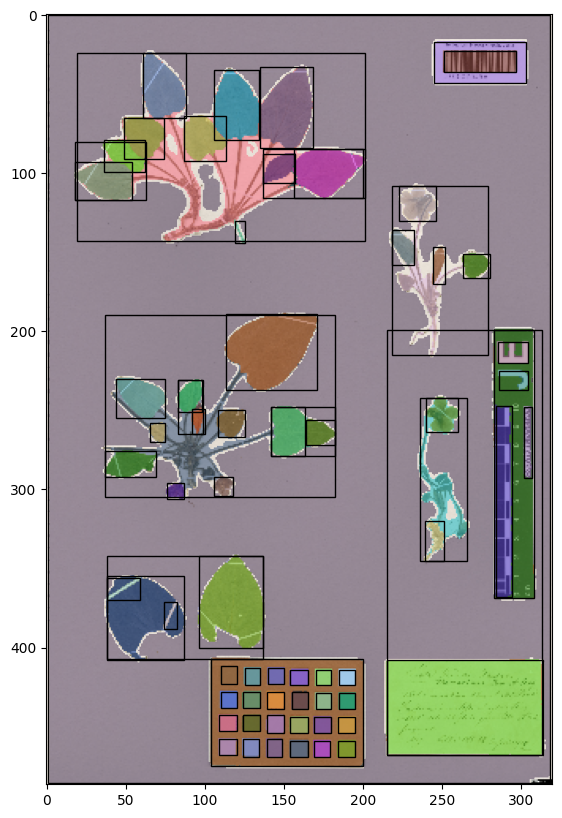

In [113]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=True)

ax.imshow(image)

sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)

img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
img[:,:,3] = 0
for ann in sorted_anns:
    m = ann['segmentation']
    color_mask = np.concatenate([np.random.random(3), [0.5]])
    img[m] = color_mask
ax.imshow(img)

for ann in sorted_anns:
    bb = ann['bbox']
    rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor=(0,0,0), facecolor='none')
    ax.add_patch(rect)

#ax.axis('off')
plt.savefig('jena.png', dpi=900)

### Segment with point prompt

In [131]:
mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image)

masks, scores, logits = mask_predictor.predict(
    point_coords=np.array([[155, 50]]), #[155, 50] [235, 115]
    point_labels=np.array([1]),
    multimask_output=True
)

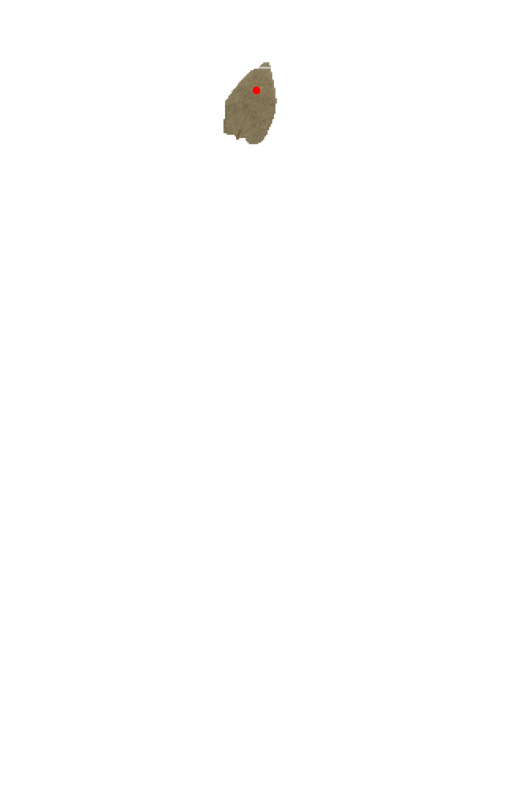

In [132]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=True)

r_channel, g_channel, b_channel = cv2.split(image)
alpha_channel = (masks[0]*255).astype('uint8')
img_masked = cv2.merge((r_channel, g_channel, b_channel, alpha_channel))

#ax.imshow(image)
ax.scatter(155, 50, c=(1,0,0), s=20)
#ax.scatter(235, 115, c=(1,0,0), s=20)
ax.imshow(img_masked)
ax.axis('off')
#rect = patches.Rectangle((bbox[0],bbox[1]), 20, 20, linewidth=1, edgecolor=(0,0,0), facecolor='none')
#ax.add_patch(rect)

plt.savefig('jena.png', dpi=1200)

# Detectron2

In [78]:
#https://github.com/bnsreenu/python_for_microscopists/blob/master/329_Detectron2_intro.ipynb

In [259]:
import detectron2
# import some common detectron2 utilities
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

### Predict with pretrained model

In [253]:
# Inference with instance segmentation
cfg_inst = get_cfg()
cfg_inst.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg_inst.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg_inst.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set threshold for this model
cfg_inst.MODEL.DEVICE = 'cpu'
predictor = DefaultPredictor(cfg_inst)

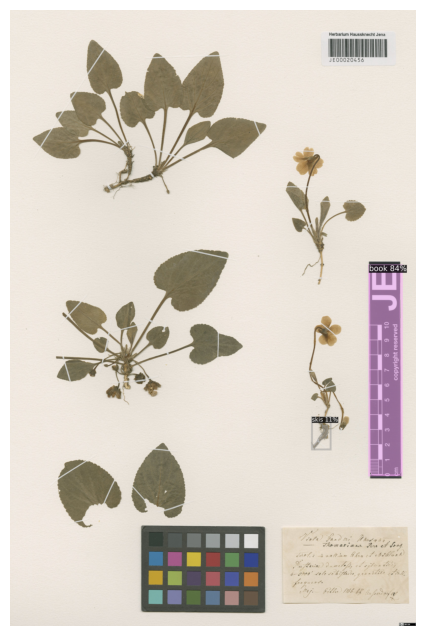

In [261]:
image = cv2.imread(f'images_Viola/{img_ID}.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (0,0), fx=1, fy=1)

sci_outputs = predictor(image)
sci_v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg_inst.DATASETS.TRAIN[0]))
sci_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), sharey=True)
ax.axis('off')
ax.imshow(sci_out.get_image()[:, :, ::-1])
plt.savefig('jena.png', dpi=1200)

### Download training data from Roboflow and train model

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("jena-digital-collectomics").project("viola-uny05")
version = project.version(7)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Viola-7 in coco-segmentation:: 100%|███████████████████████████████████████████████████████| 14/14 [00:00<00:00, 763.53it/s]


In [264]:
#register datasets
register_coco_instances('my_dataset_train', {}, 'Viola-7/train/_annotations.coco.json', 'Viola-7/train')
#register_coco_instances('my_dataset_val', {}, 'Viola-5/valid/_annotations.coco.json', 'Viola.v4i.coco-segmentation/valid')

train_metadata = MetadataCatalog.get('my_dataset_train')
train_dataset_dicts = DatasetCatalog.get('my_dataset_train')
#val_metadata = MetadataCatalog.get('my_dataset_val')
#val_dataset_dicts = DatasetCatalog.get('my_dataset_val')


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [ ]:
model_arch = 'mask_rcnn_R_50_FPN_3x'
max_iter = 1000

cfg = get_cfg()
cfg.OUTPUT_DIR = 'Detectron2_Models'
cfg.merge_from_file(model_zoo.get_config_file(f'COCO-InstanceSegmentation/{model_arch}.yaml'))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f'COCO-InstanceSegmentation/{model_arch}.yaml')
cfg.DATASETS.TRAIN = ('my_dataset_train',)
cfg.DATASETS.TEST = ()
#cfg.DATASETS.TEST = ('my_dataset_val')
#cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
#cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = max_iter
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 #number of classes plus 1
cfg.INPUT.MIN_SIZE_TRAIN = (1000,)
cfg.INPUT.MAX_SIZE_TRAIN = 1200
cfg.MODEL.DEVICE = 'cpu'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


In [ ]:
trainer.train()

In [270]:
##save model config file and rename weights
#model_nam = f'{model_arch}_{max_iter}'
#config_yaml_path = f'Detectron2_Models/{model_arch}_{max_iter}.yaml'
#with open(config_yaml_path, 'w') as file:
#    yaml.dump(cfg, file)
#os.rename(os.path.join(cfg.OUTPUT_DIR, 'model_final.pth'), os.path.join(cfg.OUTPUT_DIR, f'{model_arch}_{max_iter}.pth'))

### Predict with the trained model and visualize images

In [298]:
cfg = get_cfg()
cfg.merge_from_file('Detectron2_Models/mask_rcnn_R_50_FPN_3x_1000.yaml')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
#Find a model from detectron2's model zoo. https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = 'Detectron2_Models/mask_rcnn_R_50_FPN_3x_1000.pth'
cfg.MODEL.DEVICE = 'cpu'
predictor = DefaultPredictor(cfg)

Loading config Detectron2_Models/mask_rcnn_R_50_FPN_3x_1000.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [299]:
#extract metadata
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).as_dict()
class_dic = {metadata['thing_classes'][k]:k for k in metadata['thing_dataset_id_to_contiguous_id'].keys()}

In [300]:
class_dic

{'organs': 0, 'Flower': 1, 'Leaf': 2, 'Scale': 3}

In [301]:
def get_axes(mask, pixel_size):
    props = measure.regionprops(label(mask))[0]
    min_bx, min_by, max_bx, max_by = props.bbox
    diagon = geometry.Point(min_bx, min_by).distance(geometry.Point(max_bx, max_by))
    xc, yc = props.centroid
    cont = measure.find_contours(mask, 0.8)
    poly = geometry.Polygon(geometry.Point(i) for i in cont[0])
    
    dist = 0
    #calculate major axis
    for ir in np.arange(0, 2*np.pi, 0.005):
        x1 = xc + math.cos(0 + ir) * diagon
        y1 = yc - math.sin(0 + ir) * diagon
        
        x0 = xc + math.cos(np.pi + ir) * diagon
        y0 = yc - math.sin(np.pi + ir) * diagon
    
        intersection = poly.exterior.intersection(geometry.LineString([[x0, y0], [x1, y1]]))
    
        new_dist = intersection.geoms[0].distance(intersection.geoms[1])
        
        if new_dist > dist:
            major_axis = geometry.LineString([intersection.geoms[0], intersection.geoms[1]])
            major_axis_rad = ir
            dist = new_dist
    
    #calculate minor axis
    dist_minor = 0
    segmented_major = shapely.segmentize(major_axis, 1)
    
    minor_axis_rad = major_axis_rad - np.pi/2
    for ipm in range(1, len(segmented_major.xy[0])):
        xm = segmented_major.xy[0][ipm]
        ym = segmented_major.xy[1][ipm]
        
        x1 = xm + math.cos(0 + minor_axis_rad) * diagon
        y1 = ym - math.sin(0 + minor_axis_rad) * diagon
        
        x0 = xm + math.cos(np.pi + minor_axis_rad) * diagon
        y0 = ym - math.sin(np.pi + minor_axis_rad) * diagon
    
        intersection = poly.exterior.intersection(geometry.LineString([[x0, y0], [x1, y1]]))
    
        new_dist = intersection.geoms[0].distance(intersection.geoms[1])
    
        if new_dist > dist_minor:
            minor_axis = geometry.LineString([intersection.geoms[0], intersection.geoms[1]])
            dist_minor = new_dist

    return [dist*pixel_size, dist_minor*pixel_size, major_axis, minor_axis, poly]

In [436]:
def plot_masks(obj, color):
    obj_indx = np.where(all_instances == class_dic[obj])[0]
    obj_masks = np.sum(all_masks[obj_indx], axis = 0) > 0
    r_channel, g_channel, b_channel = cv2.split(image)
    r_channel[:] = color[0]
    g_channel[:] = color[1]
    b_channel[:] = color[2]
    alpha_channel = (obj_masks*color[3]).astype('uint8')
    img_masked = cv2.merge((r_channel, g_channel, b_channel, alpha_channel))

    ax.imshow(img_masked)

def plot_boxes(obj, color, txt_color):
    obj_indx = np.where(all_instances == class_dic[obj])[0]
    #get individual boxes
    for bb in all_bboxes[obj_indx]:
        rect = patches.Rectangle((bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth=1,
                                 edgecolor=(color), facecolor='none')
        ax.add_patch(rect)
        ax.text(bb[0], bb[1], obj, fontsize=8, fontweight=580, va='bottom', c=txt_color)

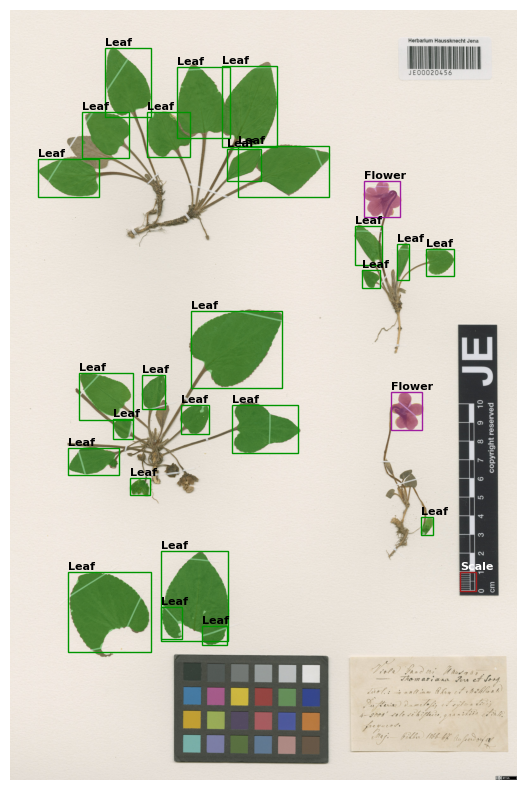

In [438]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=True)

image = cv2.imread('images_Viola/3029007469.jpeg') 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#r_channel, g_channel, b_channel = cv2.split(image)
#alpha_channel = (all_masks[1]*255).astype('uint8')
#img_masked = cv2.merge((r_channel, g_channel, b_channel, alpha_channel))

ax.imshow(image)

#predict classes
pred_output = predictor(image)

#extract predictions
all_instances = pred_output['instances'].get('pred_classes').numpy()
all_scores = pred_output['instances'].get('scores').numpy()
all_masks = pred_output['instances'].get('pred_masks').numpy()
all_bboxes = pred_output['instances'].get('pred_boxes').tensor.numpy()

#plot predicted objects
plot_masks('Leaf', (0, 150, 0, 100))
plot_masks('Flower', (160, 30, 160, 100))
plot_boxes('Leaf', (0/255, 150/255, 0/255, 255/255), (0,0,0,1))
plot_boxes('Flower', (160/255, 30/255, 160/255, 255/255), (0,0,0,1))
plot_boxes('Scale', (160/255, 30/255, 30/255, 255/255), (1,1,1,1))

#plot geometry
#d1, d2, major, minor, perim = get_axes(all_masks[1], 1)
#ax.plot(major.xy[1], major.xy[0], color=(.6,0,0,1), lw=0.5, ls=(0, (2, 1)))
#ax.plot(minor.xy[1], minor.xy[0], color=(.6,0,0,1), lw=0.5, ls=(0, (2, 1)))
#ax.plot(perim.exterior.xy[1], perim.exterior.xy[0], color=(.6,0,0,1), lw=0.5, ls=(0, (2, 1)))

plt.axis('off')
plt.savefig('jena.png', dpi=1200)

### Hypothesis testing elevation - size

In [ ]:
#extract leaf and flower traits from specimens
#img_dic = {}
species = 'thomasiana'#'odorata'
img_dic[species] = {}

#enumerate([i.split('.')[0] for i in os.listdir('Viola_odorata')])
#enumerate(viola_records.dropna(subset=['elevation'])['gbifID'].values)

for idx, img_id in enumerate(viola_records.dropna(subset=['elevation'])['gbifID'].values):
    print(idx, img_id)
    viola_img = cv2.imread(f'images_Viola/{img_id}.jpeg')
    viola_img = cv2.cvtColor(viola_img, cv2.COLOR_BGR2RGB)

    pred_output = predictor(viola_img)

    #get pixel area
    scale_instance = pred_output['instances'].get('pred_classes').numpy()
    scale_indx = np.where(scale_instance == class_dic['Scale'])
    scale_box = pred_output['instances'].get('pred_boxes').tensor.numpy()[scale_indx]
    pixel_size = 1 / (scale_box[0][3] - scale_box[0][1])
    pixel_area = pixel_size**2
    
    #get leafs masks and area
    leaf_instance = pred_output['instances'].get('pred_classes').numpy()
    leaf_indx = np.where(leaf_instance == class_dic['Leaf'])
    leaf_scores = pred_output['instances'].get('scores').numpy()[leaf_indx]
    leaf_masks = pred_output['instances'].get('pred_masks').numpy()[leaf_indx]

    #get flower masks and area
    flower_instance = pred_output['instances'].get('pred_classes').numpy()
    flower_indx = np.where(flower_instance == class_dic['Flower'])
    flower_scores = pred_output['instances'].get('scores').numpy()[flower_indx]
    flower_masks = pred_output['instances'].get('pred_masks').numpy()[flower_indx]
    
    leaf_area_list = []
    leaf_axes_list = []
    for leaf_m in leaf_masks:
        leaf_area = regionprops(label(leaf_m))[0].area
        leaf_area_list.append(leaf_area*pixel_area)
        leaf_axes_list.append(get_axes(leaf_m, pixel_size))

    flower_area_list = []
    for flower_m in flower_masks:
        flower_area = regionprops(label(flower_m))[0].area
        flower_area_list.append(flower_area*pixel_area)

    img_dic[species][img_id] = {}
    img_dic[species][img_id]['leaf_area'] = leaf_area_list
    img_dic[species][img_id]['leaf_axes'] = leaf_axes_list
    img_dic[species][img_id]['flower'] = flower_area_list

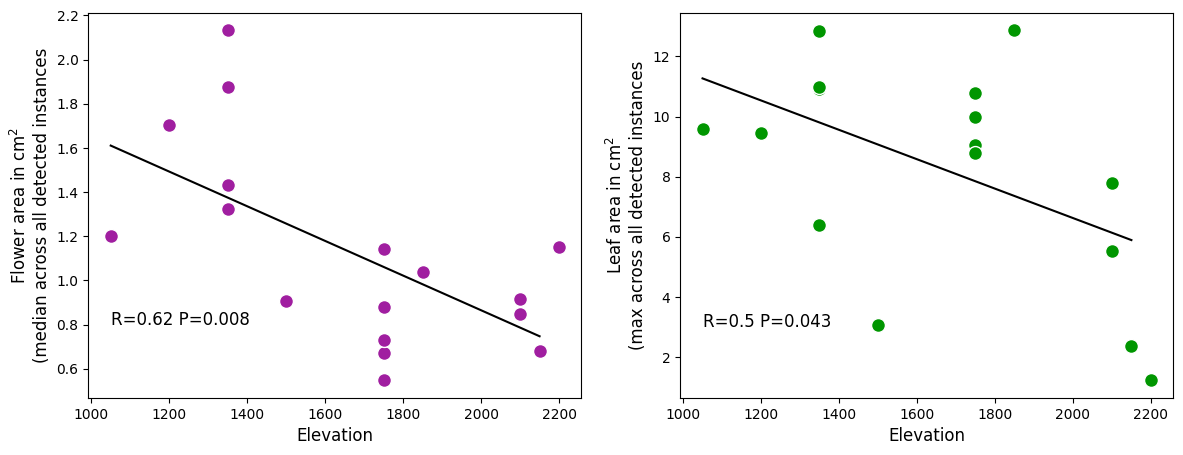

In [409]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

#plot elevation - flower area
X = [viola_records[viola_records['gbifID'] == k]['elevation'] for k in img_dic['thomasiana'].keys()]
Y = [np.median(a['flower']) for a in img_dic['thomasiana'].values()]
regr = sm.OLS(Y,sm.add_constant(X)).fit()
ax[0].scatter(X, Y,s=100, facecolor=(160/255, 30/255, 160/255, 255/255), edgecolor=(1, 1, 1))
X_plot = np.linspace(1050,2150,100)
ax[0].plot(X_plot, X_plot * regr.params[1] + regr.params[0], color='black')
ax[0].text(1050, .8, 'R=' + str(np.round(np.sqrt(regr.rsquared), 2)) +' P=' + str(np.round(regr.pvalues[1], 3)), fontsize=12 )
ax[0].set_ylabel('Flower area in cm$^2$\n(median across all detected instances', fontsize=12)
ax[0].set_xlabel('Elevation', fontsize=12)


#plot elevation - leaf area
Y = [np.max(a['leaf_area']) for a in img_dic['thomasiana'].values()]
regr = sm.OLS(Y,sm.add_constant(X)).fit()
ax[1].scatter(X, Y,s=100, facecolor=(0/255, 150/255, 0/255), edgecolor=(1, 1, 1))
X_plot = np.linspace(1050,2150,100)
ax[1].plot(X_plot, X_plot * regr.params[1] + regr.params[0], color='black')
ax[1].text(1050, 3, 'R=' + str(np.round(np.sqrt(regr.rsquared), 2)) +' P=' + str(np.round(regr.pvalues[1], 3)), fontsize=12 )
ax[1].set_ylabel('Leaf area in cm$^2$\n(max across all detected instances', fontsize=12)
ax[1].set_xlabel('Elevation', fontsize=12)

plt.savefig('jena.png', dpi=1200)

### Interspecific leaf differences

In [475]:
leaf_ratio_list_o = []
for img in img_dic['odorata']:
    for leaf in img_dic['odorata'][img]['leaf_axes']:
        leaf_ratio = leaf[0] / leaf [1]
        leaf_ratio_list_o.append(leaf_ratio)

In [445]:
leaf_ratio_list_t = []
for img in img_dic['thomasiana']:
    for leaf in img_dic['thomasiana'][img]['leaf_axes']:
        leaf_ratio = leaf[0] / leaf [1]
        leaf_ratio_list_t.append(leaf_ratio)

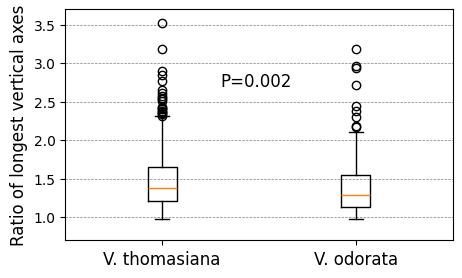

In [467]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))

ax.boxplot([leaf_ratio_list_t, leaf_ratio_list_o])

ax.set_xticklabels(['V. thomasiana', 'V. odorata'], fontsize=12)
ax.set_ylabel('Ratio of longest vertical axes', fontsize=12)

for ig in ax.get_yticks():
    ax.axhline(ig, 0, 1, ls='--', lw=0.5, color=(0,0,0,0.5))

k_test = stats.kruskal(leaf_ratio_list_s, leaf_ratio_list_t)

ax.set_ylim(0.7, 3.7)
ax.text(1.3, 2.7, f'P={np.round(k_test[1], 3)}', fontsize = 12)

plt.savefig('jena.png', dpi=1200)